In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn

In [0]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.fc3(x)
        
        return out

In [0]:
class IterNet(nn.Module):
    def __init__(self, iter_depth=2):
        super(IterNet, self).__init__()
        
        self.iter_depth = iter_depth
        
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.input = nn.Linear(16*4*4, 120)
        self.iterative = nn.Linear(120, 120)
        self.out = nn.Linear(120, 10)
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.input(x))
        
        #Iterative Block
        for i in range(self.iter_depth):
            x = F.relu(self.iterative(self.iterative(x))+self.iterative(x))
            
        out = self.out(x)
        
        return out

In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))
                               ])

In [0]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [0]:
ROOT = './data'
BATCH = 64

train_data = datasets.MNIST(root=ROOT, download=True, train=True, transform=transform)
test_data = datasets.MNIST(root=ROOT, download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH, shuffle=True)

loaders = {'train': train_loader,
           'test': test_loader}

torch.Size([64, 1, 28, 28])
torch.Size([64])


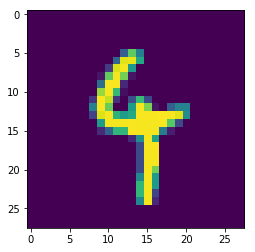

In [0]:
data_iter = iter(train_loader)
images, labels = data_iter.next()

print(images.shape)
print(labels.shape)

plt.imshow(images[0].squeeze())

In [0]:
lenet = LeNet()
print(lenet)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [0]:
iternet = IterNet(iter_depth=2)
print(iternet)

IterNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (input): Linear(in_features=256, out_features=120, bias=True)
  (iterative): Linear(in_features=120, out_features=120, bias=True)
  (out): Linear(in_features=120, out_features=10, bias=True)
)


In [0]:
model_parameters = filter(lambda p: p.requires_grad, lenet.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

print(params)

44426


In [0]:
model_parameters = filter(lambda p: p.requires_grad, iternet.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

print(params)

49142


In [0]:
def weights_init(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
def train_model(epochs, loaders, model, optimizer, criterion, device, verbose=True):
    assert type(loaders) == dict and len(loaders) == 2, ValueError("Improper Loader dict")
    
    model = model.to(device)
    
    train_losses = []
    
    for e in range(1, epochs+1):
        train_loss = 0
        
        #Train loop
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
            train_losses.append(loss.item())
            
        train_loss = train_loss / len(loaders['train'])
            
        if verbose:
            print("  Epoch {}\n\tTrain Loss: {:.4f}".format(e, train_loss))
        
    return train_losses, model

In [0]:
def test_model(loaders, model, criterion, device):
    test_loss = 0
    correct = 0
    total = 0
    
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        test_loss + ((1 / (batch_idx+1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        
    print('Test Loss: {:.4f}'.format(test_loss))
    print('Test Accuracy: {:.2%}'.format(correct / total))
    
    return correct / total

In [0]:
def trial_evaluation(n_trials, epochs, loaders, model_name, device, iter_depth=2, verbose=False):
    assert model_name in ['LeNet', 'IterNet'], ValueError('Invalid model type')

    print("Testing {} instances of {} model for {} epochs per trial...".format(n_trials,
                                                                               model_name,
                                                                               epochs
                                                                              ))
    
    train_losses = []
    trained_models = []
    test_accuracies = []
    
    #Run trials
    for trial in range(1, n_trials+1):
        if model_name == 'LeNet':
            model = LeNet()
        elif model_name == 'IterNet':
            model = IterNet(iter_depth=iter_depth)
    
        #Initialize weights with kaiming_normal
        weights_init(model)
        
        #SGD with Nesterov Momentum and L2 weight decay
        optimizer = optim.SGD(model.parameters(), 
                              lr=0.003,
                              momentum=0.9,
                              nesterov=True,
                              weight_decay=1e-4
                             )

        #CrossEntropyLoss
        criterion = nn.CrossEntropyLoss()
    
        print("Trial: ", trial)
        train_loss, trained_model = train_model(epochs, 
                                                loaders, 
                                                model, 
                                                optimizer, 
                                                criterion, 
                                                device, 
                                                verbose
                                               )
        test_accuracy = test_model(loaders,
                                   trained_model,
                                   criterion,
                                   device
                                  )
        
        train_losses.append(train_loss)
        test_accuracies.append(test_accuracy)
        trained_models.append(trained_model)
    
    return train_losses, test_accuracies, trained_models

In [0]:
TRIALS = 7
EPOCHS = 10

In [0]:
import time

In [0]:
time_0 = time.time()
_, LN_Accuracies, _ = trial_evaluation(TRIALS, EPOCHS, loaders, 'LeNet', device, verbose=True)
time_elapsed = time.time()-time_0
print("Total: {:.2f}\tAverage: {:.2f}".format(time_elapsed, time_elapsed/TRIALS))

Testing 7 instances of LeNet model for 10 epochs per trial...
Trial:  1
  Epoch 1
	Train Loss: 16.2925
  Epoch 2
	Train Loss: 5.6579
  Epoch 3
	Train Loss: 4.1169
  Epoch 4
	Train Loss: 3.3693
  Epoch 5
	Train Loss: 2.8489
  Epoch 6
	Train Loss: 2.4326
  Epoch 7
	Train Loss: 2.1382
  Epoch 8
	Train Loss: 1.8797
  Epoch 9
	Train Loss: 1.6860
  Epoch 10
	Train Loss: 1.4972
Test Loss: 0.0000
Test Accuracy: 98.74%
Trial:  2
  Epoch 1
	Train Loss: 16.6515
  Epoch 2
	Train Loss: 5.6186
  Epoch 3
	Train Loss: 4.0944
  Epoch 4
	Train Loss: 3.2980
  Epoch 5
	Train Loss: 2.7628
  Epoch 6
	Train Loss: 2.4261
  Epoch 7
	Train Loss: 2.1081
  Epoch 8
	Train Loss: 1.8988
  Epoch 9
	Train Loss: 1.6625
  Epoch 10
	Train Loss: 1.5350
Test Loss: 0.0000
Test Accuracy: 98.63%
Trial:  3
  Epoch 1
	Train Loss: 17.6816
  Epoch 2
	Train Loss: 6.1127
  Epoch 3
	Train Loss: 4.4820
  Epoch 4
	Train Loss: 3.5951
  Epoch 5
	Train Loss: 3.0138
  Epoch 6
	Train Loss: 2.6330
  Epoch 7
	Train Loss: 2.2612
  Epoch 8
	Tr

In [0]:
time_0 = time.time()
_, IN2_Accuracies, _ = trial_evaluation(TRIALS, EPOCHS, loaders, 'IterNet', device, verbose=True)
time_elapsed = time.time()-time_0
print("Total: {:.2f}\tAverage: {:.2f}".format(time_elapsed, time_elapsed/TRIALS))

Testing 7 instances of IterNet model for 10 epochs per trial...
Trial:  1
  Epoch 1
	Train Loss: 16.4225
  Epoch 2
	Train Loss: 5.2418
  Epoch 3
	Train Loss: 3.9495
  Epoch 4
	Train Loss: 3.0507
  Epoch 5
	Train Loss: 2.5643
  Epoch 6
	Train Loss: 2.1921
  Epoch 7
	Train Loss: 1.8600
  Epoch 8
	Train Loss: 1.6313
  Epoch 9
	Train Loss: 1.4037
  Epoch 10
	Train Loss: 1.2573
Test Loss: 0.0000
Test Accuracy: 98.40%
Trial:  2
  Epoch 1
	Train Loss: 26.4764
  Epoch 2
	Train Loss: 7.3255
  Epoch 3
	Train Loss: 5.3947
  Epoch 4
	Train Loss: 4.3045
  Epoch 5
	Train Loss: 3.6404
  Epoch 6
	Train Loss: 3.0728
  Epoch 7
	Train Loss: 2.7488
  Epoch 8
	Train Loss: 2.5284
  Epoch 9
	Train Loss: 2.1888
  Epoch 10
	Train Loss: 2.0026
Test Loss: 0.0000
Test Accuracy: 98.24%
Trial:  3
  Epoch 1
	Train Loss: 39.7468
  Epoch 2
	Train Loss: 8.5665
  Epoch 3
	Train Loss: 6.3181
  Epoch 4
	Train Loss: 5.1419
  Epoch 5
	Train Loss: 4.3552
  Epoch 6
	Train Loss: 3.8359
  Epoch 7
	Train Loss: 3.4453
  Epoch 8
	

In [0]:
time_0 = time.time()
_, IN3_Accuracies, _ = trial_evaluation(TRIALS, EPOCHS, loaders, 'IterNet', device, iter_depth=3, verbose=False)
time_elapsed = time.time()-time_0
print("Total: {:.2f}\tAverage: {:.2f}".format(time_elapsed, time_elapsed/TRIALS))

In [0]:
time_0 = time.time()
_, IN1_Accuracies, _ = trial_evaluation(TRIALS, EPOCHS, loaders, 'IterNet', device, iter_depth=1, verbose=False)
time_elapsed = time.time()-time_0
print("Total: {:.2f}\tAverage: {:.2f}".format(time_elapsed, time_elapsed/TRIALS))

In [0]:
IN1_Accuracies = np.array(IN1_Accuracies)

print("Max: ", np.max(IN1_Accuracies))
print("Min: ", np.min(IN1_Accuracies))
print("Mean: ", np.mean(IN1_Accuracies))
print("SDev: ", np.std(IN1_Accuracies))

In [0]:
IN2_Accuracies = np.array(IN2_Accuracies)

print("Max: ", np.max(IN2_Accuracies))
print("Min: ", np.min(IN2_Accuracies))
print("Mean: ", np.mean(IN2_Accuracies))
print("SDev: ", np.std(IN2_Accuracies))

In [0]:
IN3_Accuracies = np.array(IN3_Accuracies)

print("Max: ", np.max(IN3_Accuracies))
print("Min: ", np.min(IN3_Accuracies))
print("Mean: ", np.mean(IN3_Accuracies))
print("SDev: ", np.std(IN3_Accuracies))

In [0]:
LN_Accuracies = np.array(LN_Accuracies)

print("Max: ", np.max(LN_Accuracies))
print("Min: ", np.min(LN_Accuracies))
print("Mean: ", np.mean(LN_Accuracies))
print("SDev: ", np.std(LN_Accuracies))

Max:  0.9874
Min:  0.9829
Mean:  0.9857857142857143
SDev:  0.0013829870068892641
